In [1]:
import tensorflow as tf
import shutil
import numpy as np
import pandas as pd
import cv2
import os
import time
import matplotlib.pyplot as plt
import glob

import efficientnet.tfkeras as enet
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
tf.compat.v1.enable_eager_execution()

''' Seed for reproducible results '''
# Seed value
# Apparently you may use different seed values at each stage
seed_value = 0
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os

os.environ['PYTHONHASHSEED'] = str(seed_value)
# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random

random.seed(seed_value)
# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)
# 4. Set the `tensorflow` pseudo-random generator at a fixed value

c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\asus\appdata\

In [2]:
''' Read labels '''
# all_files = glob.glob("cropped_data/*.jpg")
def data_chooser(number):
    all_files = glob.glob("cropped_data/*.jpg")
    if number == 1:
        all_files = all_files[:int(len(all_files) * 0.7)]
        return all_files
    elif number == 2:
        all_files = all_files[int(len(all_files) * 0.2):int(len(all_files) * 0.5)]
        return all_files
    elif number == 3:
        all_files = all_files[int(len(all_files) * 0.5):int(len(all_files) * 0.8)]
        return all_files
    elif number == 4:
        all_files = all_files[int(len(all_files) * 0.7):]
        return all_files
# all_files = np.random.choice(all_files, int(len(all_files) * 0.6), replace=False)
# all_files = all_files[:int(len(all_files) * 0.9)]

# #1
# all_files = all_files[:int(len(all_files) * 0.3)]

# #2 
# all_files = all_files[int(len(all_files) * 0.2):int(len(all_files) * 0.5)]

#3
all_files = data_chooser(3)


# #4
# all_files = all_files[int(len(all_files) * 0.7):]

print(len(all_files))



4373


In [3]:
def pre_process(all_files):
    ''' Read label '''
    labels = np.zeros(len(all_files), dtype=np.float)
    for i in range(len(all_files)):
        file = all_files[i].split('\\')[1]
        file = file.split('.')[0]
        labels[i] = int(file.split('_')[1])
    print(labels)
    print(labels.shape)

    ''' Read images '''
    dataset = np.array([cv2.imread(i, cv2.IMREAD_GRAYSCALE) for i in all_files], dtype=np.float)
    print(dataset.shape)
    
    ''' Normalization '''
    print('Normalization')
    dataset = dataset.astype('float32')
    print(np.max(dataset))
    print(np.min(dataset))
    dataset /= np.float(255)
    # dataset -= 0.5
    # dataset *= 2
    print(np.max(dataset))
    print(np.min(dataset))
    
    ''' Stack '''
    dataset = np.stack((dataset,) * 3, axis=-1)
    print(dataset.shape)
    
    x_test_1 = dataset
    y_test1 = labels
    return x_test_1, y_test1


x_test_1, y_test1 = pre_process(all_files)

[1. 0. 0. ... 0. 1. 1.]
(4373,)
(4373, 120, 120)
Normalization
255.0
0.0
1.0
0.0
(4373, 120, 120, 3)


In [4]:
def buil_model_function(model_name, number):
    if model_name == 'enet':
        model = enet.EfficientNetB3(include_top=False, pooling='avg', input_shape=(120, 120, 3))
        x = model.output
        x = tf.keras.layers.Dense(256, activation="relu")(x)
        x = tf.keras.layers.Dense(128, activation="relu")(x)

        # output layer
        predictions = tf.keras.layers.Dense(2, activation="softmax")(x)
        model_final = tf.keras.models.Model(inputs=model.input, outputs=predictions)
#         enetb3_cropped_bahman_4
        model_final.load_weights('enetb3_cropped_bahman_{}.h5'.format(number))
        return model_final
    
    elif model_name == 'Xception':
        model = tf.keras.applications.Xception(include_top=False, 
                                          pooling='avg', 
                                          input_shape=(120, 120, 3), 
                                          weights='imagenet')
        x = model.output
        x = tf.keras.layers.Dense(256, activation="relu")(x)
        x = tf.keras.layers.Dense(128, activation="relu")(x)

        # output layer
        predictions = tf.keras.layers.Dense(2, activation="softmax")(x)
        model_final = tf.keras.models.Model(inputs=model.input, outputs=predictions)
        
        model_final.load_weights('Xception_cropped_bahman_{}.h5'.format(number))
        return model_final
    
    elif model_name == 'MobileNetV2':
        model = tf.keras.applications.MobileNetV2(include_top=False, 
                                          pooling='avg', 
                                          input_shape=(120, 120, 3), 
                                          weights='imagenet')
        x = model.output
        x = tf.keras.layers.Dense(256, activation="relu")(x)
        x = tf.keras.layers.Dense(128, activation="relu")(x)

        # output layer
        predictions = tf.keras.layers.Dense(2, activation="softmax")(x)
        model_final = tf.keras.models.Model(inputs=model.input, outputs=predictions)
        
        model_final.load_weights('MobileNetV2_cropped_bahman_{}.h5'.format(number))
        return model_final
    
    elif model_name == 'InceptionV3':
        model = tf.keras.applications.InceptionV3(include_top=False, 
                                          pooling='avg', 
                                          input_shape=(120, 120, 3), 
                                          weights='imagenet')
        x = model.output
        x = tf.keras.layers.Dense(256, activation="relu")(x)
        x = tf.keras.layers.Dense(128, activation="relu")(x)

        # output layer
        predictions = tf.keras.layers.Dense(2, activation="softmax")(x)
        model_final = tf.keras.models.Model(inputs=model.input, outputs=predictions)
        
        model_final.load_weights('InceptionV3_cropped_bahman_{}.h5'.format(number))
        return model_final
    
    elif model_name == 'ResNet50':
        model = tf.keras.applications.ResNet50(include_top=False, 
                                          pooling='avg', 
                                          input_shape=(120, 120, 3), 
                                          weights='imagenet')
        x = model.output
        x = tf.keras.layers.Dense(256, activation="relu")(x)
        x = tf.keras.layers.Dense(128, activation="relu")(x)

        # output layer
        predictions = tf.keras.layers.Dense(2, activation="softmax")(x)
        model_final = tf.keras.models.Model(inputs=model.input, outputs=predictions)
        
        model_final.load_weights('ResNet50_cropped_bahman_{}.h5'.format(number))
        return model_final
    else:
        return 'Invalid model name'

models = []
for i in range(1, 5):
    model_final1 = buil_model_function('enet', i)
    model_final2 = buil_model_function('Xception', i)
    model_final3 = buil_model_function('MobileNetV2', i)
    model_final4 = buil_model_function('InceptionV3', i)
    model_final5 = buil_model_function('ResNet50', i)
    models.append([model_final1, model_final2, model_final3, model_final4, model_final5])
print(len(models))

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


4


In [5]:
print(len(models[1]))

5


In [6]:
all_files = data_chooser(i)
x_test_1, y_test1 = pre_process(all_files)


[0. 0. 1. ... 0. 1. 0.]
(4374,)
(4374, 120, 120)
Normalization
255.0
0.0
1.0
0.0
(4374, 120, 120, 3)


In [7]:
from sklearn.metrics import accuracy_score
def weighted_classes(preds1, ideal_weights1):
    ideal_weights_preds1 = np.tensordot(preds1, ideal_weights1, axes= ((0), (0)))
    ideal_weights_ensemble_predictions1 = np.argmax(ideal_weights_preds1, axis = 1)
    return ideal_weights_ensemble_predictions1

def results(y_test1, y_pred1):
    acc = accuracy_score(y_test1, y_pred1)
    cm = confusion_matrix(y_test1, y_pred1)
    tn, fp, fn, tp = confusion_matrix(y_test1, y_pred1).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    f2_score = 5 * (precision * recall) / (4 * precision + recall)
    return acc, cm, precision, recall, f1_score, f2_score

In [8]:
# all_predictions_total = []
# for j in range(1, 5):
#     all_files = data_chooser(j)
#     x_test_1, y_test1 = pre_process(all_files)
#     model_sample = models[j-1]
#     preds = [model.predict(x_test_1) for model in model_sample]
#     preds = np.array(preds)
#     all_predictions = np.argmax(preds, axis=2)
#     all_predictions_total.append(all_predictions)

[1. 0. 1. ... 0. 0. 0.]
(10204,)
(10204, 120, 120)
Normalization
255.0
0.0
1.0
0.0
(10204, 120, 120, 3)
0.9669737357898863 [[4930  145]
 [ 192 4937]] 0.9714679260133806 0.9625658023006434 0.9669963764567623 0.964333151027424
0.9551156409251274 [[4948  127]
 [ 331 4798]] 0.9742131979695432 0.9354650029245467 0.9544459916451165 0.9429660783774224
0.9524696197569581 [[4765  310]
 [ 175 4954]] 0.9411094224924013 0.965880288555274 0.9533339747907246 0.960822342901474
0.9307134457075656 [[4801  274]
 [ 433 4696]] 0.9448692152917505 0.9155780853967636 0.9299930686206556 0.9212901200659186
0.9159153273226186 [[4889  186]
 [ 672 4457]] 0.9599396941632565 0.8689803080522519 0.9121981170691773 0.8857665249016258
[0.20137228 0.20165661 0.19820085 0.19859637 0.20017389]
[0.20274398 0.20331691 0.1964082  0.19719286 0.20033805]
0.5 0.971187769502156 [[4954  121]
 [ 173 4956]] 0.9761670277723065 0.9662702281146422 0.9711934156378601 0.9682335013480248
[0.20164667 0.20198838 0.1978418  0.19831565 0.200

3.7999999999999994 0.9708937671501372 [[4955  120]
 [ 177 4952]] 0.9763406940063092 0.9654903489959057 0.9708852073326146 0.9676410817570738
[0.2106816  0.21301305 0.18614529 0.18906242 0.20109765]
[0.20274398 0.20331691 0.1964082  0.19719286 0.20033805]
3.8999999999999995 0.9708937671501372 [[4955  120]
 [ 177 4952]] 0.9763406940063092 0.9654903489959057 0.9708852073326146 0.9676410817570738
[0.21095457 0.21334924 0.18579566 0.18878256 0.20111797]
[0.20274398 0.20331691 0.1964082  0.19719286 0.20033805]
3.999999999999999 0.9708937671501372 [[4955  120]
 [ 177 4952]] 0.9763406940063092 0.9654903489959057 0.9708852073326146 0.9676410817570738
[0.21122749 0.21368555 0.18544632 0.18850275 0.2011379 ]
[0.20274398 0.20331691 0.1964082  0.19719286 0.20033805]
4.1 0.9709917679341434 [[4955  120]
 [ 176 4953]] 0.9763453577764636 0.9656853187755898 0.9709860811605567 0.9677986634882176
[0.21150034 0.21402196 0.18509727 0.18822298 0.20115744]
[0.20274398 0.20331691 0.1964082  0.19719286 0.200338

7.399999999999999 0.970795766366131 [[4955  120]
 [ 178 4951]] 0.9763360283967659 0.9652953792162214 0.9707843137254901 0.967483487708602
[0.22046377 0.22517947 0.17374993 0.17902409 0.20158274]
[0.20274398 0.20331691 0.1964082  0.19719286 0.20033805]
7.499999999999998 0.9709917679341434 [[4957  118]
 [ 178 4951]] 0.9767212467942396 0.9652953792162214 0.9709747009217493 0.9675591166699237
[0.22073395 0.22551906 0.17341143 0.17874657 0.20158899]
[0.20274398 0.20331691 0.1964082  0.19719286 0.20033805]
7.599999999999999 0.9709917679341434 [[4957  118]
 [ 178 4951]] 0.9767212467942396 0.9652953792162214 0.9709747009217493 0.9675591166699237
[0.22100404 0.22585873 0.17307325 0.17846913 0.20159485]
[0.20274398 0.20331691 0.1964082  0.19719286 0.20033805]
7.699999999999998 0.9709917679341434 [[4957  118]
 [ 178 4951]] 0.9767212467942396 0.9652953792162214 0.9709747009217493 0.9675591166699237
[0.22127403 0.22619847 0.1727354  0.17819178 0.20160032]
[0.20274398 0.20331691 0.1964082  0.1971928

11.199999999999998 0.9708937671501372 [[4959  116]
 [ 181 4948]] 0.9770932069510269 0.964710469877169 0.9708623565191798 0.9671618451915559
[0.23065493 0.23812849 0.16112185 0.16854709 0.20154763]
[0.20274398 0.20331691 0.1964082  0.19719286 0.20033805]
11.299999999999997 0.9710897687181498 [[4960  115]
 [ 180 4949]] 0.9772906793048973 0.9649054396568532 0.9710585696065928 0.967357310398749
[0.23092078 0.23847024 0.16079624 0.16827355 0.2015392 ]
[0.20274398 0.20331691 0.1964082  0.19719286 0.20033805]
11.399999999999997 0.9710897687181498 [[4960  115]
 [ 180 4949]] 0.9772906793048973 0.9649054396568532 0.9710585696065928 0.967357310398749
[0.23118649 0.23881202 0.16047097 0.16800014 0.20153038]
[0.20274398 0.20331691 0.1964082  0.19719286 0.20033805]
11.499999999999998 0.9710897687181498 [[4960  115]
 [ 180 4949]] 0.9772906793048973 0.9649054396568532 0.9710585696065928 0.967357310398749
[0.23145207 0.23915384 0.16014607 0.16772684 0.20152118]
[0.20274398 0.20331691 0.1964082  0.19719

14.599999999999996 0.9712857702861623 [[4964  111]
 [ 182 4947]] 0.9780545670225386 0.9645155000974849 0.9712378521645234 0.9671932431375615
[0.23961385 0.24976259 0.15025303 0.15932262 0.2010479 ]
[0.20274398 0.20331691 0.1964082  0.19719286 0.20033805]
14.699999999999998 0.9713837710701686 [[4965  110]
 [ 182 4947]] 0.978247973106585 0.9645155000974849 0.9713332024347142 0.967231064012826
[0.23987468 0.25010503 0.14993979 0.15905388 0.20102662]
[0.20274398 0.20331691 0.1964082  0.19719286 0.20033805]
14.799999999999997 0.9712857702861623 [[4965  110]
 [ 183 4946]] 0.978243670886076 0.9643205303178007 0.9712322042218949 0.9670733614891286
[0.24013534 0.25044748 0.14962692 0.15878529 0.20100497]
[0.20274398 0.20331691 0.1964082  0.19719286 0.20033805]
14.899999999999997 0.971187769502156 [[4965  110]
 [ 184 4945]] 0.9782393669634025 0.9641255605381166 0.9711311861743911 0.9669156466309491
[0.24039584 0.25078993 0.14931443 0.15851686 0.20098295]
[0.20274398 0.20331691 0.1964082  0.19719

18.199999999999996 0.9714817718541748 [[4969  106]
 [ 185 4944]] 0.979009900990099 0.9639305907584325 0.9714117300324198 0.9669091762497065
[0.24889474 0.26208559 0.13921596 0.14975347 0.20005024]
[0.20274398 0.20331691 0.1964082  0.19719286 0.20033805]
18.299999999999997 0.9714817718541748 [[4969  106]
 [ 185 4944]] 0.979009900990099 0.9639305907584325 0.9714117300324198 0.9669091762497065
[0.24914916 0.26242754 0.13891652 0.14949096 0.20001582]
[0.20274398 0.20331691 0.1964082  0.19719286 0.20033805]
18.399999999999995 0.9714817718541748 [[4969  106]
 [ 185 4944]] 0.979009900990099 0.9639305907584325 0.9714117300324198 0.9669091762497065
[0.24940339 0.26276946 0.13861747 0.14922864 0.19998103]
[0.20274398 0.20331691 0.1964082  0.19719286 0.20033805]
18.499999999999996 0.9714817718541748 [[4969  106]
 [ 185 4944]] 0.979009900990099 0.9639305907584325 0.9714117300324198 0.9669091762497065
[0.24965743 0.26311135 0.13831882 0.1489665  0.1999459 ]
[0.20274398 0.20331691 0.1964082  0.19719

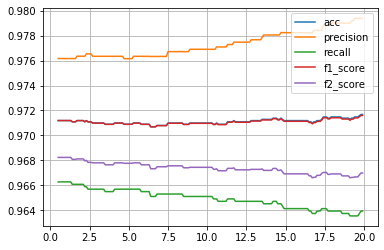

[1. 1. 1. ... 0. 1. 1.]
(4374,)
(4374, 120, 120)
Normalization
255.0
0.0
1.0
0.0
(4374, 120, 120, 3)
0.9419295839048926 [[2067   89]
 [ 165 2053]] 0.9584500466853408 0.9256086564472498 0.941743119266055 0.9319956419102959
0.9291266575217193 [[1999  157]
 [ 153 2065]] 0.9293429342934293 0.9310189359783588 0.9301801801801801 0.9306832522084008
0.9183813443072703 [[2034  122]
 [ 235 1983]] 0.9420427553444181 0.89404869251578 0.9174184594031923 0.9032522547144028
0.9080932784636488 [[1926  230]
 [ 172 2046]] 0.8989455184534271 0.9224526600541028 0.9105473965287049 0.9176533907427342
0.881572930955647 [[2037  119]
 [ 399 1819]] 0.9385964912280702 0.8201082055906221 0.8753609239653514 0.8413506012950972
[0.20266909 0.19956794 0.2009269  0.19627702 0.20055904]
[0.20535086 0.19911457 0.20183555 0.19260183 0.20109718]
0.5 0.9469593049839964 [[2062   94]
 [ 138 2080]] 0.9567617295308187 0.9377817853922452 0.947176684881603 0.9415172913271772
[0.20320444 0.19947896 0.2011101  0.19553816 0.2006683

[0.2250102  0.19525052 0.2078296  0.1675545  0.20435518]
[0.20535086 0.19911457 0.20183555 0.19260183 0.20109718]
4.599999999999999 0.9483310470964792 [[2067   89]
 [ 137 2081]] 0.9589861751152073 0.9382326420198377 0.9484958979033729 0.9423111755116826
[0.22556454 0.19512884 0.20798219 0.16689415 0.20443028]
[0.20535086 0.19911457 0.20183555 0.19260183 0.20109718]
4.699999999999999 0.9483310470964792 [[2067   89]
 [ 137 2081]] 0.9589861751152073 0.9382326420198377 0.9484958979033729 0.9423111755116826
[0.2261193  0.19500643 0.20813402 0.1662357  0.20450455]
[0.20535086 0.19911457 0.20183555 0.19260183 0.20109718]
4.799999999999999 0.9483310470964792 [[2067   89]
 [ 137 2081]] 0.9589861751152073 0.9382326420198377 0.9484958979033729 0.9423111755116826
[0.22667448 0.19488328 0.20828509 0.16557916 0.20457799]
[0.20535086 0.19911457 0.20183555 0.19260183 0.20109718]
4.899999999999999 0.9483310470964792 [[2068   88]
 [ 138 2080]] 0.959409594095941 0.9377817853922452 0.9484724122207023 0.94

9.099999999999998 0.9483310470964792 [[2067   89]
 [ 137 2081]] 0.9589861751152073 0.9382326420198377 0.9484958979033729 0.9423111755116826
[0.25091351 0.18893134 0.21405947 0.13913353 0.20696215]
[0.20535086 0.19911457 0.20183555 0.19260183 0.20109718]
9.199999999999998 0.9483310470964792 [[2067   89]
 [ 137 2081]] 0.9589861751152073 0.9382326420198377 0.9484958979033729 0.9423111755116826
[0.25148507 0.18877863 0.21417694 0.13855952 0.20699985]
[0.20535086 0.19911457 0.20183555 0.19260183 0.20109718]
9.299999999999997 0.9483310470964792 [[2067   89]
 [ 137 2081]] 0.9589861751152073 0.9382326420198377 0.9484958979033729 0.9423111755116826
[0.25205695 0.1886253  0.21429365 0.13798734 0.20703675]
[0.20535086 0.19911457 0.20183555 0.19260183 0.20109718]
9.399999999999999 0.9481024234110654 [[2067   89]
 [ 138 2080]] 0.958967266021208 0.9377817853922452 0.9482562115340779 0.941943664523141
[0.25262916 0.18847138 0.2144096  0.13741699 0.20707287]
[0.20535086 0.19911457 0.20183555 0.1926018

17.199999999999996 0.948559670781893 [[2072   84]
 [ 141 2077]] 0.961129106894956 0.936429215509468 0.9486184060287736 0.9412671077676062
[0.29811207 0.1748527  0.22113075 0.09835917 0.20754532]
[0.20535086 0.19911457 0.20183555 0.19260183 0.20109718]
17.299999999999997 0.9483310470964792 [[2072   84]
 [ 142 2076]] 0.9611111111111111 0.9359783588818755 0.9483782549109183 0.9408992023205222
[0.29870419 0.17466052 0.22118771 0.09792487 0.20752271]
[0.20535086 0.19911457 0.20183555 0.19260183 0.20109718]
17.399999999999995 0.9483310470964792 [[2072   84]
 [ 142 2076]] 0.9611111111111111 0.9359783588818755 0.9483782549109183 0.9408992023205222
[0.29929649 0.17446797 0.22124396 0.09749216 0.20749942]
[0.20535086 0.19911457 0.20183555 0.19260183 0.20109718]
17.499999999999996 0.9483310470964792 [[2072   84]
 [ 142 2076]] 0.9611111111111111 0.9359783588818755 0.9483782549109183 0.9408992023205222
[0.29988897 0.17427505 0.22129949 0.09706104 0.20747544]
[0.20535086 0.19911457 0.20183555 0.1926

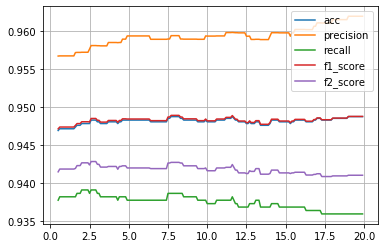

[1. 0. 0. ... 0. 1. 1.]
(4373,)
(4373, 120, 120)
Normalization
255.0
0.0
1.0
0.0
(4373, 120, 120, 3)
0.9368854333409559 [[1998  166]
 [ 110 2099]] 0.9267108167770419 0.9502037120869171 0.9383102369244524 0.9454103233942887
0.9217928195746627 [[2045  119]
 [ 223 1986]] 0.9434679334916865 0.8990493435943866 0.9207232267037551 0.9075952837949
0.9238509032700664 [[1954  210]
 [ 123 2086]] 0.9085365853658537 0.9443186962426438 0.9260821309655939 0.9369385555156308
0.9071575577406814 [[1968  196]
 [ 210 1999]] 0.9107061503416857 0.9049343594386601 0.9078110808356041 0.9060828574018673
0.9124171049622685 [[1954  210]
 [ 173 2036]] 0.9065004452359751 0.9216840199185151 0.9140291806958473 0.9186067496841726
[0.20082301 0.20263055 0.19884403 0.19908131 0.19862109]
[0.20163763 0.20528372 0.19768321 0.19815527 0.19724017]
0.5 0.952435399039561 [[2048  116]
 [  92 2117]] 0.948051948051948 0.9583521955636034 0.9531742458352094 0.9562742795193786
[0.20098661 0.20315938 0.19861225 0.19889669 0.1983450

4.799999999999999 0.9528927509718729 [[2052  112]
 [  94 2115]] 0.9497081275258195 0.9574468085106383 0.9535617673579802 0.9558889993672604
[0.20768186 0.22674349 0.18847324 0.19068887 0.18641254]
[0.20163763 0.20528372 0.19768321 0.19815527 0.19724017]
4.899999999999999 0.9528927509718729 [[2052  112]
 [  94 2115]] 0.9497081275258195 0.9574468085106383 0.9535617673579802 0.9558889993672604
[0.20782915 0.2273113  0.18823371 0.19049196 0.18613387]
[0.20163763 0.20528372 0.19768321 0.19815527 0.19724017]
4.999999999999999 0.9531214269380288 [[2053  111]
 [  94 2115]] 0.9501347708894878 0.9574468085106383 0.9537767756482526 0.9559754113180258
[0.20797604 0.22787997 0.18799403 0.19029479 0.18585516]
[0.20163763 0.20528372 0.19768321 0.19815527 0.19724017]
5.099999999999999 0.9528927509718729 [[2053  111]
 [  95 2114]] 0.9501123595505618 0.9569941149841558 0.9535408209291837 0.9556098001988972
[0.20812252 0.22844951 0.1877542  0.19009736 0.18557642]
[0.20163763 0.20528372 0.19768321 0.19815

9.399999999999999 0.9526640750057169 [[2056  108]
 [  99 2110]] 0.951307484220018 0.9551833408782254 0.9532414727806642 0.9544056450153792
[0.21401555 0.25373653 0.17730791 0.18137135 0.17356867]
[0.20163763 0.20528372 0.19768321 0.19815527 0.19724017]
9.499999999999998 0.9526640750057169 [[2056  108]
 [  99 2110]] 0.951307484220018 0.9551833408782254 0.9532414727806642 0.9544056450153792
[0.21414269 0.25434265 0.1770622  0.18116321 0.17328925]
[0.20163763 0.20528372 0.19768321 0.19815527 0.19724017]
9.599999999999998 0.9526640750057169 [[2056  108]
 [  99 2110]] 0.951307484220018 0.9551833408782254 0.9532414727806642 0.9544056450153792
[0.21426935 0.25494958 0.17681638 0.18095485 0.17300984]
[0.20163763 0.20528372 0.19768321 0.19815527 0.19724017]
9.699999999999998 0.9526640750057169 [[2056  108]
 [  99 2110]] 0.951307484220018 0.9551833408782254 0.9532414727806642 0.9544056450153792
[0.21439555 0.2555573  0.17657044 0.18074626 0.17273045]
[0.20163763 0.20528372 0.19768321 0.19815527 

14.299999999999997 0.9515206951749371 [[2054  110]
 [ 102 2107]] 0.950383400992332 0.9538252602987777 0.9521012200632626 0.9531348955034833
[0.21966682 0.28434028 0.16515752 0.17092854 0.15990683]
[0.20163763 0.20528372 0.19768321 0.19815527 0.19724017]
14.399999999999997 0.9515206951749371 [[2054  110]
 [ 102 2107]] 0.950383400992332 0.9538252602987777 0.9521012200632626 0.9531348955034833
[0.21976934 0.28498324 0.16490766 0.17071066 0.1596291 ]
[0.20163763 0.20528372 0.19768321 0.19815527 0.19724017]
14.499999999999996 0.9515206951749371 [[2054  110]
 [ 102 2107]] 0.950383400992332 0.9538252602987777 0.9521012200632626 0.9531348955034833
[0.21987133 0.28562691 0.16465774 0.17049261 0.15935142]
[0.20163763 0.20528372 0.19768321 0.19815527 0.19724017]
14.599999999999996 0.9515206951749371 [[2054  110]
 [ 102 2107]] 0.950383400992332 0.9538252602987777 0.9521012200632626 0.9531348955034833
[0.21997279 0.28627127 0.16440776 0.17027438 0.1590738 ]
[0.20163763 0.20528372 0.19768321 0.19815

18.999999999999996 0.9501486393780014 [[2050  114]
 [ 104 2105]] 0.9486255069851285 0.9529198732458126 0.9507678410117435 0.9520578923563998
[0.22389253 0.31527768 0.15337162 0.16052021 0.14693795]
[0.20163763 0.20528372 0.19768321 0.19815527 0.19724017]
19.099999999999994 0.9501486393780014 [[2050  114]
 [ 104 2105]] 0.9486255069851285 0.9529198732458126 0.9507678410117435 0.9520578923563998
[0.22396891 0.31595093 0.15312036 0.16029547 0.14666433]
[0.20163763 0.20528372 0.19768321 0.19815527 0.19724017]
19.199999999999996 0.9501486393780014 [[2050  114]
 [ 104 2105]] 0.9486255069851285 0.9529198732458126 0.9507678410117435 0.9520578923563998
[0.22404471 0.31662477 0.1528691  0.16007061 0.14639081]
[0.20163763 0.20528372 0.19768321 0.19815527 0.19724017]
19.299999999999997 0.9501486393780014 [[2050  114]
 [ 104 2105]] 0.9486255069851285 0.9529198732458126 0.9507678410117435 0.9520578923563998
[0.22411992 0.31729918 0.15261784 0.15984564 0.14611741]
[0.20163763 0.20528372 0.19768321 0.1

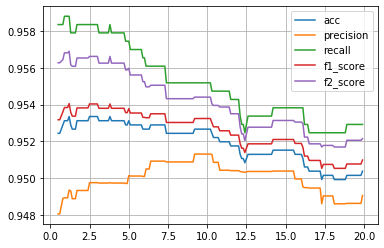

[0. 0. 1. ... 0. 1. 0.]
(4374,)
(4374, 120, 120)
Normalization
255.0
0.0
1.0
0.0
(4374, 120, 120, 3)
0.9401005944215821 [[2078  136]
 [ 126 2034]] 0.9373271889400921 0.9416666666666667 0.9394919168591225 0.940795559666975
0.9350708733424783 [[2063  151]
 [ 133 2027]] 0.9306703397612488 0.9384259259259259 0.9345320424158596 0.9368644851173968
0.9252400548696845 [[2046  168]
 [ 159 2001]] 0.9225449515905948 0.9263888888888889 0.9244629244629246 0.9256175409381072
0.9128943758573388 [[1986  228]
 [ 153 2007]] 0.897986577181208 0.9291666666666667 0.9133105802047782 0.9227586206896552
0.9218106995884774 [[2019  195]
 [ 147 2013]] 0.9116847826086957 0.9319444444444445 0.9217032967032968 0.9278207964601772
[0.20187574 0.20115761 0.20027756 0.19759386 0.19909524]
[0.20375731 0.20231023 0.20054393 0.1952054  0.19818313]
0.5 0.9492455418381345 [[2093  121]
 [ 101 2059]] 0.9444954128440367 0.9532407407407407 0.9488479262672812 0.9514787430683919
[0.20225159 0.20138853 0.20033173 0.19711475 0.1989

4.399999999999999 0.9492455418381345 [[2092  122]
 [ 100 2060]] 0.9440879926672777 0.9537037037037037 0.9488714877936434 0.9517649233043799
[0.21708075 0.21022883 0.20209462 0.17898851 0.19160729]
[0.20375731 0.20231023 0.20054393 0.1952054  0.19818313]
4.499999999999999 0.9492455418381345 [[2092  122]
 [ 100 2060]] 0.9440879926672777 0.9537037037037037 0.9488714877936434 0.9517649233043799
[0.21746508 0.21045099 0.20213086 0.17853823 0.19141484]
[0.20375731 0.20231023 0.20054393 0.1952054  0.19818313]
4.599999999999999 0.9492455418381345 [[2092  122]
 [ 100 2060]] 0.9440879926672777 0.9537037037037037 0.9488714877936434 0.9517649233043799
[0.21784961 0.2106729  0.20216664 0.17808869 0.19122215]
[0.20375731 0.20231023 0.20054393 0.1952054  0.19818313]
4.699999999999999 0.9492455418381345 [[2092  122]
 [ 100 2060]] 0.9440879926672777 0.9537037037037037 0.9488714877936434 0.9517649233043799
[0.21823433 0.21089458 0.20220198 0.17763989 0.19102923]
[0.20375731 0.20231023 0.20054393 0.19520

8.799999999999999 0.949702789208962 [[2092  122]
 [  98 2062]] 0.9441391941391941 0.9546296296296296 0.9493554327808471 0.9525129342202512
[0.23415816 0.21976613 0.20326685 0.15987447 0.18293439]
[0.20375731 0.20231023 0.20054393 0.1952054  0.19818313]
8.899999999999999 0.949702789208962 [[2092  122]
 [  98 2062]] 0.9441391941391941 0.9546296296296296 0.9493554327808471 0.9525129342202512
[0.2345499  0.21997695 0.20328351 0.15945676 0.18273287]
[0.20375731 0.20231023 0.20054393 0.1952054  0.19818313]
8.999999999999998 0.9499314128943759 [[2093  121]
 [  98 2062]] 0.9445716903344022 0.9546296296296296 0.9495740271701589 0.9526009424374018
[0.23494179 0.2201875  0.20329973 0.1590398  0.18253117]
[0.20375731 0.20231023 0.20054393 0.1952054  0.19818313]
9.099999999999998 0.9499314128943759 [[2093  121]
 [  98 2062]] 0.9445716903344022 0.9546296296296296 0.9495740271701589 0.9526009424374018
[0.23533382 0.22039778 0.20331551 0.15862358 0.1823293 ]
[0.20375731 0.20231023 0.20054393 0.1952054

13.099999999999998 0.9499314128943759 [[2094  120]
 [  99 2061]] 0.9449793672627235 0.9541666666666667 0.949550794747754 0.952314943166066
[0.2511214  0.22857315 0.20358941 0.14258756 0.17412848]
[0.20375731 0.20231023 0.20054393 0.1952054  0.19818313]
13.199999999999998 0.9501600365797896 [[2095  119]
 [  99 2061]] 0.9454128440366972 0.9541666666666667 0.9497695852534562 0.9524029574861366
[0.25151845 0.22877144 0.20358742 0.14220198 0.1739207 ]
[0.20375731 0.20231023 0.20054393 0.1952054  0.19818313]
13.299999999999997 0.9499314128943759 [[2095  119]
 [ 100 2060]] 0.945387792565397 0.9537037037037037 0.9495275409080433 0.9520288381550975
[0.25191561 0.22896943 0.20358501 0.14181714 0.17371282]
[0.20375731 0.20231023 0.20054393 0.1952054  0.19818313]
13.399999999999997 0.9499314128943759 [[2095  119]
 [ 100 2060]] 0.945387792565397 0.9537037037037037 0.9495275409080433 0.9520288381550975
[0.25231286 0.22916711 0.20358217 0.14143305 0.17350481]
[0.20375731 0.20231023 0.20054393 0.19520

17.699999999999996 0.9506172839506173 [[2096  118]
 [  98 2062]] 0.9458715596330275 0.9546296296296296 0.9502304147465438 0.9528650646950092
[0.26947557 0.23736808 0.20306446 0.12562006 0.16447183]
[0.20375731 0.20231023 0.20054393 0.1952054  0.19818313]
17.799999999999997 0.9506172839506173 [[2096  118]
 [  98 2062]] 0.9458715596330275 0.9546296296296296 0.9502304147465438 0.9528650646950092
[0.26987625 0.23755166 0.20304338 0.12526858 0.16426013]
[0.20375731 0.20231023 0.20054393 0.1952054  0.19818313]
17.899999999999995 0.9506172839506173 [[2096  118]
 [  98 2062]] 0.9458715596330275 0.9546296296296296 0.9502304147465438 0.9528650646950092
[0.270277   0.2377349  0.2030219  0.12491783 0.16404837]
[0.20375731 0.20231023 0.20054393 0.1952054  0.19818313]
17.999999999999996 0.9506172839506173 [[2096  118]
 [  98 2062]] 0.9458715596330275 0.9546296296296296 0.9502304147465438 0.9528650646950092
[0.2706778  0.23791781 0.20300001 0.12456781 0.16383656]
[0.20375731 0.20231023 0.20054393 0.1

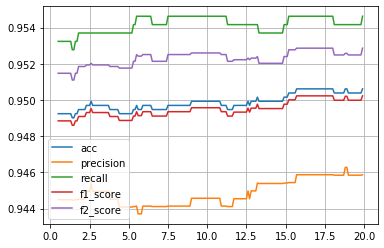

In [14]:
steps = np.arange(0.5,20, 0.1)
acc_plot_total = []
precision_plot_total = []
recall_plot_total = []
f1_score_plot_total = []
f2_score_plot_total = []
for j in range(1, 5):
    all_files = data_chooser(j)
    x_test_1, y_test1 = pre_process(all_files)
    model_sample = models[j-1]
    preds = [model.predict(x_test_1) for model in model_sample]
    preds = np.array(preds)
#     all_predictions = all_predictions_total[j-1]
    all_predictions = np.argmax(preds, axis=2)
    
    acc_list = np.zeros(len(all_predictions))
    precision_list = np.zeros(len(all_predictions))
    recall_list = np.zeros(len(all_predictions))
    f1_score_list = np.zeros(len(all_predictions))
    f2_score_list = np.zeros(len(all_predictions))
    for i in range(len(all_predictions)):
        acc, cm, precision, recall, f1_score, f2_score = results(y_test1, all_predictions[i])
        print(acc, cm, precision, recall, f1_score, f2_score)
        acc_list[i] = acc
        precision_list[i] = precision
        recall_list[i] = recall
        f1_score_list[i] = f1_score
        f2_score_list[i] = f2_score
    
    acc_plot = []
    precision_plot = []
    recall_plot = []
    f1_score_plot = []
    f2_score_plot = []
    for i in steps:
        ideal_weights = np.power(precision_list, i) / np.sum(np.power(precision_list, i))
        print(ideal_weights)
        print(np.power(precision_list, 1) / np.sum(np.power(precision_list, 1)))
        # ideal_weights = precision_list / np.sum(precision_list)
        # print(acc_list)
        # print(np.sum(acc_list))
        # print(np.sum(f1_score_list))
        # print(np.sum(np.power(acc_list, 2)))
        # print(np.sum(np.power(f1_score_list, 2)))
        # print(f1_score_list)
        # ideal_weights = [0.2, 0.2, 0.2, 0.2, 0.2]
        # ideal_weights = ideal_weights / np.sum(ideal_weights)
        # print(ideal_weights)

        ideal_weights_ensemble_predictions = weighted_classes(preds, ideal_weights)
        acc, cm, precision, recall, f1_score, f2_score = results(y_test1, ideal_weights_ensemble_predictions)
        acc_plot.append(acc)
        precision_plot.append(precision)
        recall_plot.append(recall)
        f1_score_plot.append(f1_score)
        f2_score_plot.append(f2_score)
    #     print(i)
        print(i, acc, cm, precision, recall, f1_score, f2_score)

    acc_plot_total.append(acc_plot)
    precision_plot_total.append(precision_plot)
    recall_plot_total.append(recall_plot)
    f1_score_plot_total.append(f1_score_plot)
    f2_score_plot_total.append(f2_score_plot)
    
    plt.plot(steps, acc_plot, label='acc')
    plt.plot(steps, precision_plot, label='precision')
    plt.plot(steps, recall_plot, label='recall')
    plt.plot(steps, f1_score_plot, label='f1_score')
    plt.plot(steps, f2_score_plot, label='f2_score')

    plt.grid(True)
    plt.legend()
    plt.show()

In [10]:
print(np.array(f2_score_plot_total).shape)

(4, 195)


In [11]:
acc_plot_total = np.array(acc_plot_total)
precision_plot_total = np.array(precision_plot_total)
recall_plot_total = np.array(recall_plot_total)
f1_score_plot_total = np.array(f1_score_plot_total)
f2_score_plot_total = np.array(f2_score_plot_total)

In [12]:
print(np.argmax(np.mean(acc_plot_total, axis=0)) * 0.1 + 0.5)
print(np.max(np.mean(acc_plot_total, axis=0)))
print(np.argmax(np.mean(precision_plot_total, axis=0)) * 0.1 + 0.5)
print(np.max(np.mean(precision_plot_total, axis=0)))
print(np.argmax(np.mean(recall_plot_total, axis=0)) * 0.1 + 0.5)
print(np.max(np.mean(recall_plot_total, axis=0)))
print(np.argmax(np.mean(f1_score_plot_total, axis=0)) * 0.1 + 0.5)
print(np.max(np.mean(f1_score_plot_total, axis=0)))
print(np.argmax(np.mean(f2_score_plot_total, axis=0)) * 0.1 + 0.5)
print(np.max(np.mean(f2_score_plot_total, axis=0)))

2.6
0.9556755829032973
19.900000000000002
0.9590810988956816
2.0
0.9543163782193219
2.6
0.955796240226459
2.6
0.9548401364635558


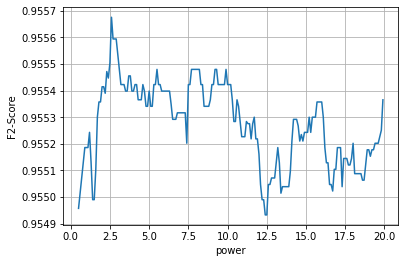

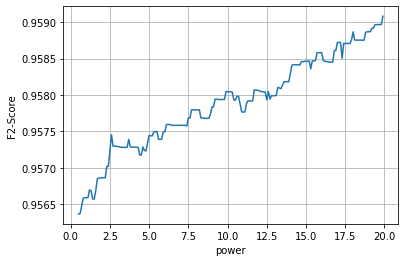

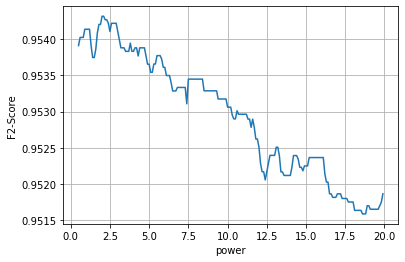

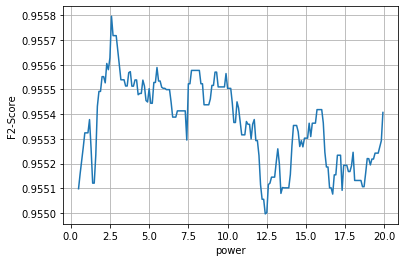

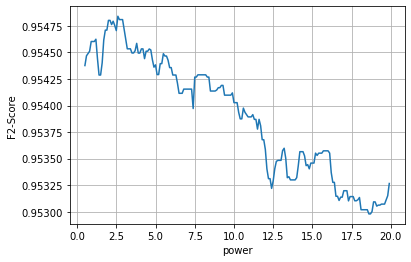

In [13]:
plt.plot(np.arange(len(np.mean(acc_plot_total, axis=0)))* 0.1 + 0.5, np.mean(acc_plot_total, axis=0))
plt.xlabel('power')
plt.ylabel('F2-Score')
plt.grid(True)
plt.show()
plt.plot(np.arange(len(np.mean(precision_plot_total, axis=0)))* 0.1 + 0.5, np.mean(precision_plot_total, axis=0))
plt.xlabel('power')
plt.ylabel('F2-Score')
plt.grid(True)
plt.show()
plt.plot(np.arange(len(np.mean(recall_plot_total, axis=0)))* 0.1 + 0.5, np.mean(recall_plot_total, axis=0))
plt.xlabel('power')
plt.ylabel('F2-Score')
plt.grid(True)
plt.show()
plt.plot(np.arange(len(np.mean(f1_score_plot_total, axis=0)))* 0.1 + 0.5, np.mean(f1_score_plot_total, axis=0))
plt.xlabel('power')
plt.ylabel('F2-Score')
plt.grid(True)
plt.show()
plt.plot(np.arange(len(np.mean(f2_score_plot_total, axis=0)))* 0.1 + 0.5, np.mean(f2_score_plot_total, axis=0))
plt.xlabel('power')
plt.ylabel('F2-Score')
plt.grid(True)
plt.show()
# np.mean(recall_plot_total, axis=0)

In [1]:
print(0.9389225**2.6)

0.8488624853749103
